#    **Impact Of Tobacco Usage On Potential Heart Failure Patients**

## *Group 18: Final Project Report*

GROUP MEMEBERS: Dua Khan, Sohbat Sandhu, Advitya Mittal

## **Introduction**

For our project, we will analyze the [UCI Heart Failure Clinical Records Dataset](https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv). 
<br>Through the analysis of this dataset, we intend to contribute to the prevention of heart failure in tobacco users given proper kidney evaluation in the early stages. 
<br>The dataset includes information on high-risk heart failure patients in Faisalabad, Pakistan. We will mainly look at patients with a history of tobacco use and analyze their serum creatinine levels. Creatinine is a waste product of muscle metabolism, which is released into a person's blood. The creatinine is filtered out of the blood by the kidneys. Therefore, higher serum creatinine levels in the blood can be associated with CKD (Chronic Kidney Disease). 
<br> According to [CDC](https://www.cdc.gov/kidneydisease/publications-resources/link-between-ckd-diabetes-heart-disease.html) (Centre for Disease and Prevention Control), Chronic Kidney Disease (CKD) is a considerable risk factor for heart failure. When kidneys stop filtering blood properly, more stress is put on the heart to pump the improperly filtered blood leading to heart diseases and even failure. 
<br>Thus, comparing the serum creatinine levels of high-risk heart failure tobacco users with those of non-tobacco users will help us determine whether or not tobacco use is associated with an increase in the serum creatinine levels, as stated in many studies [(Rudnick & Leonberg-Yoo, 2017)](https://pubmed.ncbi.nlm.nih.gov/28930748/). 

### **Data Preparation** (Import, Clean and Wrangle Data)

In [220]:
# Step 1: load libraries
library(infer)
library(tidyverse)
library(tidymodels)

In [221]:
# Step 2: assign the url for heart failure clinincal records dataset
heart_patients_url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00519/heart_failure_clinical_records_dataset.csv"

# Step 3: read the csv file and assign the dataframe
data <- read_csv(heart_patients_url)

# preview dataframe
head(data)

Rows: 299 Columns: 13
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (13): age, anaemia, creatinine_phosphokinase, diabetes, ejection_fractio...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
75,0,582,0,20,1,265000,1.9,130,1,0,4,1
55,0,7861,0,38,0,263358,1.1,136,1,0,6,1
65,0,146,0,20,0,162000,1.3,129,1,1,7,1
50,1,111,0,20,0,210000,1.9,137,1,0,7,1
65,1,160,1,20,0,327000,2.7,116,0,0,8,1
90,1,47,0,40,1,204000,2.1,132,1,1,8,1


*Table 1. Table of clinical features of 299 admitted heart failure patients*

The dataset gives clinical features of heart failure patients admitted to the Institute of Cardiology and Allied hospital at Faisalabad in Pakistan from April to December 2015. <br>
The data set contains 13 variables which tell us about the 13 clinical features of heart failure patients. We are choosing to focusing on the relevant variables:
| Column Name              | Description Of Clinical Feature                                               |
|--------------------------|-------------------------------------------------------------------------------|
| serum_creatinine         | Level of serum creatinine in the blood (in mg/dL)                             |
| smoking                  | Patient uses tobacco (1 = "True", 0 = "False")                                |


We are interested in analyzing if tobacco usage increases the amounts of the creatinine serum in bloodstream. As a first step in the analysis, we will filter out irrelevant variables from the data frame

In [222]:
# Step 4: remove N/A in dataset
# select relevant columns (smoking, serum_creatinine) for our preliminary analysis
data <- data %>%
    filter(!is.na(serum_creatinine)) %>%
    select(smoking, serum_creatinine)

# Step 5: reassign values in 'smoking' column to boolean values
smoking_patients <- data %>%
    filter(smoking == 1) %>%
    mutate(tobacco_users = "True") %>%
    select(-smoking)

non_smoking_patients <- data %>%
    filter(smoking == 0) %>%
    mutate(tobacco_users = "False") %>%
    select(-smoking)

# Step 6: combine resulting dataframes into one assigning "patients"
patients <- rbind(smoking_patients, non_smoking_patients)
head(patients)

serum_creatinine,tobacco_users
<dbl>,<chr>
1.3,True
2.1,True
1.1,True
9.4,True
4.0,True
0.9,True


*Table 2. Table of dataframe for preliminary analysis with relevant variables.*

### **Preliminary Analysis:** Creatinine Levels

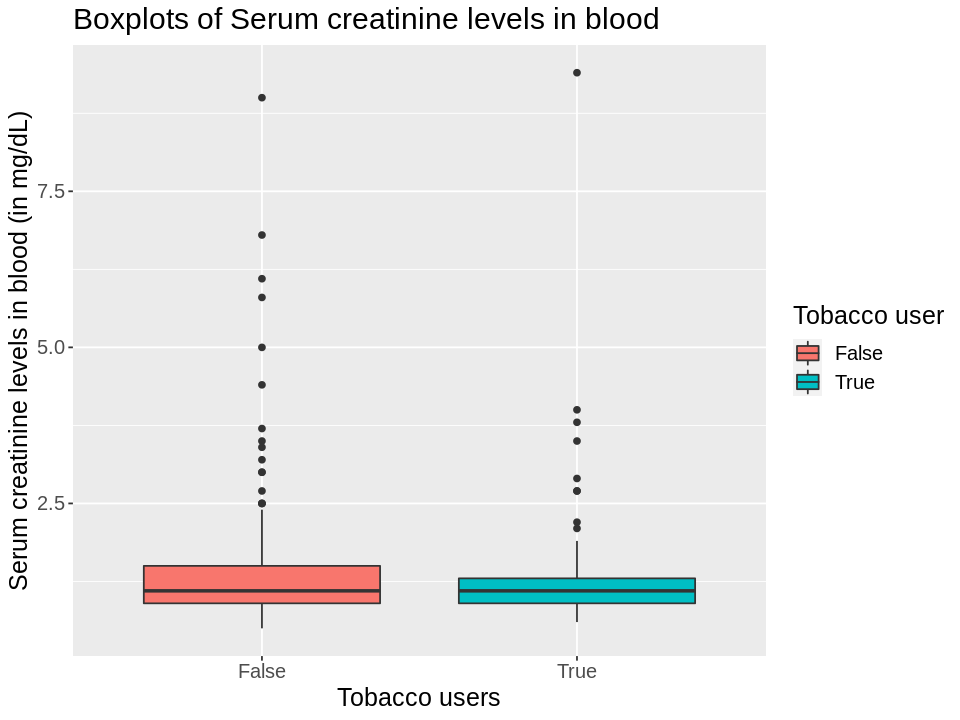

In [223]:
options(repr.plot.width = 8, repr.plot.height = 6)

# Step 7: visualise boxplot to observe difference in serum creatinine levels accoring to tobacco usage
serum_creatinine_boxplot <- patients %>%
    ggplot(aes(x = tobacco_users, y = serum_creatinine, fill = tobacco_users)) +
    geom_boxplot() +
    labs(x = "Tobacco users", y = "Serum creatinine levels in blood (in mg/dL)", fill = "Tobacco user") +
    ggtitle("Boxplots of Serum creatinine levels in blood") +
    theme(text = element_text(size = 15))
serum_creatinine_boxplot

*Figure 1. Side-by-side boxplot of serum creatinine levels in blood of heart failure patients differentiated by tobacco use*

In [224]:
# Step 8: get summary statistics for above boxplot
print("Summary Statistics for Serum Creatinine Levels of 96 Tobacco users:")
summary(smoking_patients$serum_creatinine)

print("Summary Statistics for Serum Creatinine Levels for 203 Non-tobacco users:")
summary(non_smoking_patients$serum_creatinine)

[1] "Summary Statistics for Serum Creatinine Levels of 96 Tobacco users:"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.600   0.900   1.100   1.353   1.300   9.400 

[1] "Summary Statistics for Serum Creatinine Levels for 203 Non-tobacco users:"


   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  0.500   0.900   1.100   1.413   1.500   9.000 

In [225]:
# Step 9: Removing outliers to get an easier graphical representation and comparison
lower_limit1 <- 0.900 - 1.5*IQR(smoking_patients$serum_creatinine)
upper_limit1 <- 1.300 + 1.5*IQR(smoking_patients$serum_creatinine)

clean_smoking_patients <- smoking_patients %>%
    filter(serum_creatinine >= lower_limit1 & serum_creatinine <= upper_limit1)

lower_limit2 <- 0.900 - 1.5*IQR(non_smoking_patients$serum_creatinine)
upper_limit2 <- 1.500 + 1.5*IQR(non_smoking_patients$serum_creatinine)

clean_non_smoking_patients <- non_smoking_patients %>%
    filter(serum_creatinine >= lower_limit2 & serum_creatinine <= upper_limit2)

# Binding dataframes into one cleanly wrangled dataframe assigned "clean_patients"
clean_patients <- rbind(clean_smoking_patients, clean_non_smoking_patients)
head(clean_patients)

serum_creatinine,tobacco_users
<dbl>,<chr>
1.3,True
1.1,True
0.9,True
0.9,True
1.9,True
1.3,True


*Table 3. Table of final dataframe for preliminary analysis with relevant variables.*

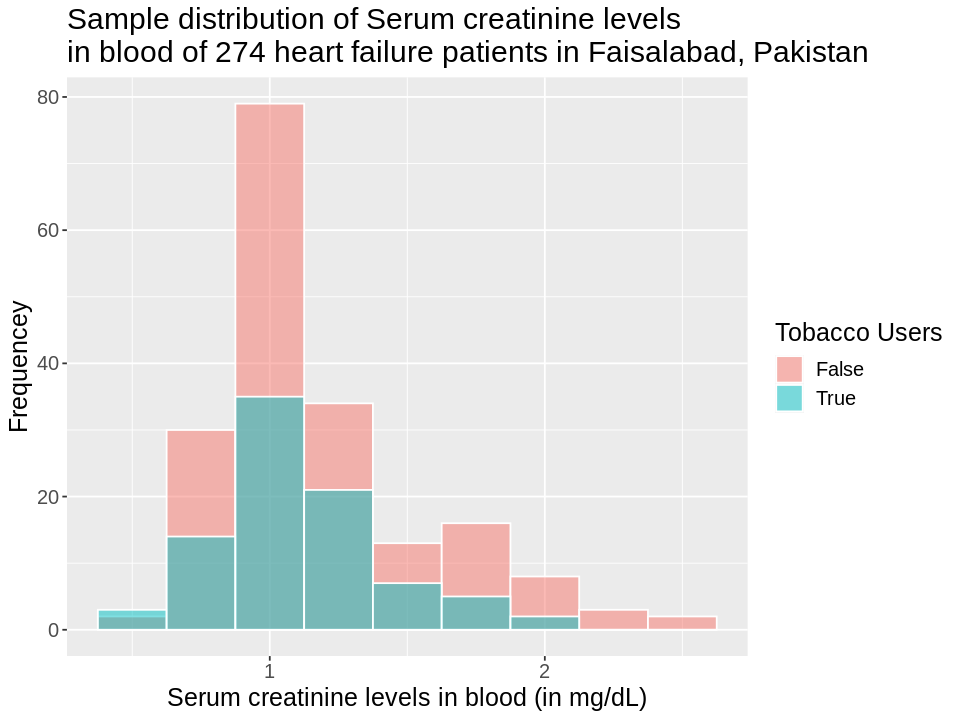

In [226]:
options(repr.plot.width = 8, repr.plot.height = 6)

# Step 10: visualise sample distibutions to observe the difference frequency in serum creatinine levels 
        # accoring to tobacco usage
sample_distribution <- clean_patients %>%
    ggplot(aes(x = serum_creatinine, fill = tobacco_users)) +
    geom_histogram(binwidth = 0.25, color = "white", alpha = 0.5, position = "identity") +
    labs(x = "Serum creatinine levels in blood (in mg/dL)", y = "Frequencey", fill = "Tobacco Users") +
    ggtitle("Sample distribution of Serum creatinine levels \nin blood of 274 heart failure patients in Faisalabad, Pakistan") +
    theme(text = element_text(size = 15))
sample_distribution

*Figure 2. Side-by-side sample distribution of serum creatinine levels in blood of heart failure patients differentiated by tobacco use*

In [227]:
# Step 11: compute the observed test statistic
obs_diff_in_creatinine_levels <- patients %>% 
    specify(formula = serum_creatinine ~ tobacco_users) %>% 
    calculate(stat = "diff in means", order = c("True", "False")) %>%
    pull()
print("The observed test statistic for hypothesis testing is:")
obs_diff_in_creatinine_levels

[1] "The observed test statistic for hypothesis testing is:"


[1] -0.06064142

From *Figure 2* and the observed test statistic, we can observe a slight difference in the mean serum creatinine levels in the blood of tobacco users and non-users. We observe that the mean serum creatinine levels are slightly higher in non-tobacco users.

## **Methods**

#### Overview

We aim to analyze a dataset of the medical records of patients having heart failure. <br>
| Variables                | Description                                                                   |
|--------------------------|-------------------------------------------------------------------------------|
| $H_0$                    | Null Hypothesis                                                               |
| $H_A$                    | Alternate Hypothesis                                                          |
| $\mu_T$                  | Population mean of Serum Creatinine levels of Tobacco Users                   |
| $\mu_T$                  | Population mean of Serum Creatinine levels of Non-tobacco Users               |
| $\hat{\mu}_T$            | Sample Mean of Serum Creatinine levels of Tobacco Users                       |
| $\hat{\mu}_N$            | Sample mean of Serum Creatinine levels of Non-tobacco Users                   |
*Table 3. Variables used and their descriptions*

Our null hypothesis is that serum creatinine levels in the blood of heart failure patients are the same for those who use tobacco and those who do not :

<center>$H_0 : \mu_T - \mu_N = 0$

Our alternative hypothesis is that serum creatinine levels in the blood of heart failure patients are higher for those who use tobacco compared to those who do not:  

<center>$H_A : \mu_T - \mu_N > 0$

Our test statistic is the difference in mean serum creatine level of the patients controlled by their preference for tobacco use. Therefore, the point estimate of interest is $\hat{\mu}_T - \hat{\mu}_N$.<br>
We will further calculate that our observed test statistic from the observed dataset is $\hat{\mu}_T - \hat{\mu}_N = -0.06064$ in favour of Tobacco users. (we have done this previously at the end of preliminary results) <br>
Assuming our null hypothesis is true, we will use infer workflow to create a null model for our hypothesis tests by generating permutations. Our test statistic with the null model provides us with a p-value for the z-test.<br>
We aim to do a two sample one-tail z-test with a significance level ($\alpha = 0.05$) using the p-value and see if our difference in means is statistically significant. According to the p-value and the $\alpha$, we will conclude if we are able to "Reject $H_0$" or "Fail to Reject $H_0$". <br> 
In addition, to gain further confidence in our result, we will create a corresponding bootstrap distribution for constructing a 95% Confidence Interval for the difference in means and interpret the results. <br>
We will also be doing an Asymptotic two sample t-test with a significance level ($\alpha = 0.05$) using the t-distribution testing package in infer workflow, to see the comparison between the bootstrapping and asymptotics.

#### **Hypothesis Testing**

In [233]:
options(repr.plot.width = 8, repr.plot.height = 6)
set.seed(456)

# Step 12: Do hypothesis testing using infer workflow with 1000 samples
null_diff_in_creatinine_levels <- patients %>%
    specify(formula = serum_creatinine ~ tobacco_users) %>%
    hypothesize(null = "independence") %>%
    generate(reps = 1000, type = "permute") %>%
    calculate(stat = "diff in means", order = c("True", "False"))

# Step 13: Get p-value
p_value <- null_diff_in_creatinine_levels %>%
    get_p_value(obs_stat = obs_diff_in_creatinine_levels, direction = "right")

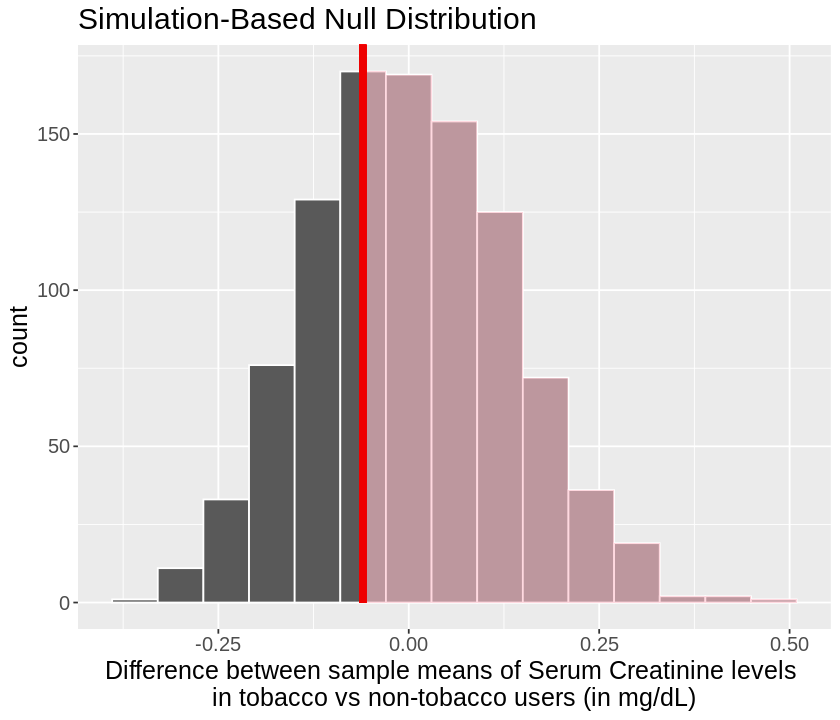

In [229]:
options(repr.plot.width = 7, repr.plot.height = 6)

# Step 14: Plot the null distribution and the shade the p-value from the corresponding test statistic
diff_in_creatinine_levels_plot <- null_diff_in_creatinine_levels %>%
    visualize(bins = 15) +
    shade_p_value(obs_stat = obs_diff_in_creatinine_levels, direction = "right") +
    xlab("Difference between sample means of Serum Creatinine levels \nin tobacco vs non-tobacco users (in mg/dL)") +
    theme(text = element_text(size = 15))
diff_in_creatinine_levels_plot

*Figure 3. Null distribution simulation and P-value of the daily temperature hypothesis test.*

**Results:** We obtain a p-value of 0.671, greater than 0.05. Hence, at a 5% significance level, there is insufficient evidence to reject the null hypothesis.

#### **Bootstrap Simulation:** With 95% Confidence interval

In [1]:
set.seed(456)

# Step 15: Do bootstrapping
diff_in_creatinine_levels_bootstrap_dist <- patients %>%
    specify(formula = serum_creatinine ~ tobacco_users) %>%
    generate(reps = 1000, type = "bootstrap") %>%
    calculate(stat = "diff in means", order = c("True", "False"))

# Step 16: Get "0.95" level confidence intervals
diff_in_creatinine_levels_ci <- 
     diff_in_creatinine_levels_bootstrap_dist %>% 
     get_confidence_interval(level = 0.95, type = "percentile")

ERROR: Error in patients %>% specify(formula = serum_creatinine ~ tobacco_users) %>% : could not find function "%>%"


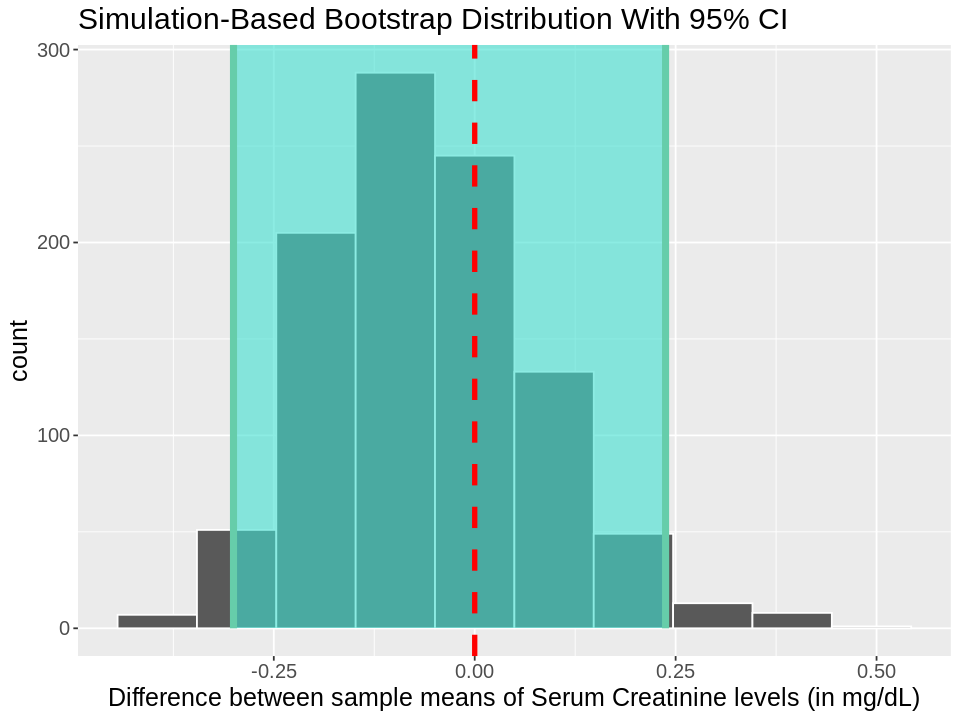

In [231]:
options(repr.plot.width = 8, repr.plot.height = 6)

# Step 17: Plot Bootstrap distribution and shade 95% confidence intervals
diff_in_creatinine_levels_ci_plot <- diff_in_creatinine_levels_bootstrap_dist %>%
    visualize(bins = 10) +
    shade_ci(diff_in_creatinine_levels_ci) +
    xlab("Difference between sample means of Serum Creatinine levels (in mg/dL)") +
    ggtitle("Simulation-Based Bootstrap Distribution With 95% CI") +
    geom_vline(xintercept = 0, size = 1.5, linetype = "dashed", color = "red") +
    theme(text = element_text(size = 15))

diff_in_creatinine_levels_ci_plot

*Figure 4. Bootstrap distribution with 95% Confidence Intervals.*

**Interpretation of 95% CI:** We are 95% "confident" that the true mean difference in the mean serum creatinine levels in the blood of heart failure patients in tobacco vs non-tobacco users in Faisalabad, Pakistan lies in the interval $(-0.300137, 0.2374877)$ **OR** If we do this experiment many times, then approximately 95% of the confidence intervals will capture the true mean difference in mean serum creatinine levels of heart failure patients in tobacco vs non-tobacco users in Faisalabad, Pakistan.

**Results:** Inclusion of $0$ in the confidence interval suggests no significant difference in the mean serum creatinine levels in the blood of tobacco users and non-users of heart failure patients in Faisalabad, Pakistan.

#### **Asymptotic Two Samples t-test**

In [232]:
# Step 18: Using built-in t-test package
t_test <- t.test(smoking_patients$serum_creatinine, 
                 non_smoking_patients$serum_creatinine, 
                 alternative = "greater")
t_test


	Welch Two Sample t-test

data:  smoking_patients$serum_creatinine and non_smoking_patients$serum_creatinine
t = -0.47134, df = 185.22, p-value = 0.681
alternative hypothesis: true difference in means is greater than 0
95 percent confidence interval:
 -0.2733267        Inf
sample estimates:
mean of x mean of y 
 1.352708  1.413350 


**Interpretation of 95% CI of t-test:** We are 95% "confident" that the true mean difference in the mean serum creatinine levels in the blood of heart failure patients in tobacco vs non-tobacco users in Faisalabad, Pakistan lies in the interval $(-0.2733267, \infty)$.

**Results:** We obtain a p-value of 0.681, greater than 0.05. Hence, at a 5% significance level, there is insufficient evidence to reject the null hypothesis.

#### **Comparing Bootstrapping and Asymptotics Methods**

|Method        |Observed Test Statistic       |Lower CI       |Upper CI       |p Value       |
|--------------|------------------------------|---------------|---------------|--------------|
|Bootstrap     |-0.06064                     |-0.300137      |0.2374877       |0.671       |
|Asymptotics   |-0.47134                     |-0.2733267      |$\infty$       |0.681      |

*Table 4. Table of estimates for the two methods of hypothesis testing*

**Conclusion:** <br>
Generally, the bootstrap method is more suitable for getting a more accurate estimate of confidence intervals when the sample size is smaller than the threshold sample size (n = 30), regardless of the skewness of the population distribution. However, for this case, as the sample size is sufficiently large (n ~ 300), both methods are appropriate, resulting in a small difference in the p-values. <br>

We observe a slight difference in the p-values of the bootstrap and asymptotic methods. The difference is due to the difference in the distributions of the methods, as mentioned earlier. The bootstrap distribution uses a z or a normal distribution, while the asymptotic method uses a t-distribution (has wider tails than the normal distribution and wider confidence intervals).

## **Discussion**

In this project, we looked at the data of 299 heart failure patients. We filtered the data for serum creatinine and tobacco user columns and plotted a boxplot. We then removed the outliers and performed a preliminary analysis. After that, we tested the hypothesis, plotted the mean creatinine levels of tobacco and non-tobacco users, and shaded the p-value. We obtained a p-value of 0.671, which is greater than the alpha of 0.05. The result indicated the likelihood of the null hypothesis holding. Furthermore, the inclusion of 0 in the 95% CI of the bootstrap distribution provides strong evidence in favour of the null hypothesis. Welch's two-sample t-test resulted in a p-value of 0.681, consistent with the previous conclusion.

According to pre-existing scientific studies, which we explored in the introduction, there is an association between high serum creatinine levels in blood and tobacco usage. Knowing that tobacco usage increases the serum creatinine levels in the blood, high serum creatinine levels may imply Chronic Kidney Disease (CKD). Since our p-value was significant, we could not reject our null hypothesis and thus could not support a positive association between tobacco usage and high serum creatinine levels. The conclusion may increase the danger of heart failure. According to the above thought process, we expected the results to support our alternative hypothesis by showing a strong connection between high creatinine levels and tobacco usage. However, our results did not support such an association and did not meet our expectations. They showed no significant difference between the serum creatinine levels of tobacco and non-tobacco users, providing insufficient evidence to reject the null hypothesis. 

Other overlooked external factors can explain this disparity in the results while performing this statistical analysis. One of the main reasons could be a generally high rate of CKD in the area, as reported by a study that explores the [prevalence of CKD in South Asia](https://bmcnephrol.biomedcentral.com/articles/10.1186/s12882-018-1072-5). Another plausible explanation could be passive smoking due to the poor air quality that may have impacted our results. AJMC reported a strong connection between high serum creatinine levels and prolonged exposure to Carbon Monoxide and Sulfur dioxide, which also happen to be one of the main contributors to the poor air quality of Faisalabad. Moreover, a study investigating [Faisalabad's air quality](https://www.researchgate.net/publication/271447511_A_preliminary_assessment_of_air_quality_index_AQI_along_a_busy_road_in_Faisalabad_metropolitan_Pakistan) reported that it lies between poor to very hazardous. In conclusion, the above factors can reasonably explain our expected and observed results disparity.

Future studies could further explore the impacts of the factors we observe that have played a significant role in our results. For example, they could look at the impact of air pollution on CKD and, thus, heart diseases in South Asia. By further exploring the main risk factors, future studies can help in the improvement of prevention methods. Moreover, further research into whether or not tobacco usage results in the imbalance of other serum levels is needed, which may explain trends in certain health conditions.

## **References**

- Leonberg-Yoo AK, Rudnick MR. Tobacco Use: A Chronic Kidney Disease Accelerant. Am J Nephrol. 2017;46(4):257-259. doi: 10.1159/000481209. Epub 2017 Sep 21. PMID: 28930748. https://pubmed.ncbi.nlm.nih.gov/28930748/
- Dua, D. and Graff, C. (2019). UCI Machine Learning Repository. Irvine, CA: University of California, School of Information and Computer Science.https://archive.ics.uci.edu/ml
- Chicco, D., Jurman, G. Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone. BMC Med Inform Decis Mak 20, 16 (2020). https://bmcmedinformdecismak.biomedcentral.com/articles/10.1186/s12911-020-1023-5
- Centers for Disease Control and Prevention. (2022, July 12). The surprising link between chronic kidney disease, diabetes, and heart disease. Centers for Disease Control and Prevention. Retrieved November 6, 2022, from https://www.cdc.gov/kidneydisease/publications-resources/link-between-ckd-diabetes-heart-disease.html
- Javed, Wasim & Murtaza, Dr. Ghulam & Ahmad, Hamaad & Iqbal, Muhammad. (2014). A preliminary assessment of air quality index (AQI) along a busy road in Faisalabad metropolitan, Pakistan. International journal of Environmental Sciences. 5. 623-633. https://www.researchgate.net/publication/271447511_A_preliminary_assessment_of_air_quality_index_AQI_along_a_busy_road_in_Faisalabad_metropolitan_Pakistan
- Hasan, M., Sutradhar, I., Gupta, R. D., & Sarker, M. (2018). Prevalence of chronic kidney disease in south asia: A systematic review. BMC Nephrology, 19(1), 291-291. https://doi.org/10.1186/s12882-018-1072-5